# Audio Classification with the STFTSpectrogram layer

**Author:** Mostafa M. Amin<br>
**Date created:** 2024/10/04<br>
**Last modified:** 2024/10/04<br>
**Description:** Introducing the `STFTSpectrogram` layer to extract spectrograms
for audio classification.


## Introduction

Preprocessing audio as spectrograms is an essential step in the vast majority
of audio-based applications. Spectrograms represent the frequency content of a
signal over time, are widely used for this purpose. In this tutorial, we'll
demonstrate how to use the `STFTSpectrogram` layer in Keras to convert raw
audio waveforms into spectrograms **within the model**. We'll then feed
these spectrograms into an LSTM network followed by Dense layers to perform
audio classification on the Speech Commands dataset.

We will:

- Load the ESC-10 dataset.
- Preprocess the raw audio waveforms and generate spectrograms using
   `STFTSpectrogram`.
- Build two models, one using spectrograms as 1D signals and the other is using
   as images (2D signals) with a pretrained image model.
- Train and evaluate the models.

## Setup

### Importing the necessary libraries

In [1]:
import os

os.environ["KERAS_BACKEND"] = "jax"

In [2]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io.wavfile
from keras import layers
from scipy.signal import resample

np.random.seed(41)
keras.utils.set_random_seed(41)

### Define some variables

In [3]:
BASE_DATA_DIR = "./datasets/esc-50_extracted/ESC-50-master/"
BATCH_SIZE = 16
NUM_CLASSES = 10
EPOCHS = 200
SAMPLE_RATE = 16000

## Download and Preprocess the ESC-10 Dataset

We'll use the Dataset for Environmental Sound Classification dataset (ESC-10).
This dataset consists of five-second .wav files of environmental sounds.

### Download and Extract the dataset

In [4]:
keras.utils.get_file(
    "esc-50.zip",
    "https://github.com/karoldvl/ESC-50/archive/master.zip",
    cache_dir="./",
    cache_subdir="datasets",
    extract=True,
)

'./datasets/esc-50_extracted'

### Read the CSV file

In [5]:
pd_data = pd.read_csv(os.path.join(BASE_DATA_DIR, "meta", "esc50.csv"))
# filter ESC-50 to ESC-10 and reassign the targets
pd_data = pd_data[pd_data["esc10"]]
targets = sorted(pd_data["target"].unique().tolist())
assert len(targets) == NUM_CLASSES
old_target_to_new_target = {old: new for new, old in enumerate(targets)}
pd_data["target"] = pd_data["target"].map(lambda t: old_target_to_new_target[t])
pd_data

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
14,1-110389-A-0.wav,1,0,dog,True,110389,A
24,1-116765-A-41.wav,1,9,chainsaw,True,116765,A
54,1-17150-A-12.wav,1,4,crackling_fire,True,17150,A
55,1-172649-A-40.wav,1,8,helicopter,True,172649,A
...,...,...,...,...,...,...,...
1876,5-233160-A-1.wav,5,1,rooster,True,233160,A
1888,5-234879-A-1.wav,5,1,rooster,True,234879,A
1889,5-234879-B-1.wav,5,1,rooster,True,234879,B
1894,5-235671-A-38.wav,5,7,clock_tick,True,235671,A


### Define functions to read and preprocess the WAV files

In [6]:
def read_wav_file(path, target_sr=SAMPLE_RATE):
    sr, wav = scipy.io.wavfile.read(os.path.join(BASE_DATA_DIR, "audio", path))
    wav = wav.astype(np.float32) / 32768.0  # normalize to [-1, 1]
    num_samples = int(len(wav) * target_sr / sr)  # resample to 16 kHz
    wav = resample(wav, num_samples)
    return wav[:, None]  # Add a channel dimension (of size 1)

Create a function that uses the `STFTSpectrogram` to compute a spectrogram,
then plots it.

In [7]:
def plot_single_spectrogram(sample_wav_data):
    spectrogram = layers.STFTSpectrogram(
        mode="log",
        frame_length=SAMPLE_RATE * 20 // 1000,
        frame_step=SAMPLE_RATE * 5 // 1000,
        fft_length=1024,
        trainable=False,
    )(sample_wav_data[None, ...])[0, ...]

    # Plot the spectrogram
    plt.imshow(spectrogram.T, origin="lower")
    plt.title("Single Channel Spectrogram")
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.show()

Create a function that uses the `STFTSpectrogram` to compute three
spectrograms with multiple bandwidths, then aligns them as an image
with different channels, to get a multi-bandwith spectrogram, then plots the spectrogram.

In [8]:
def plot_multi_bandwidth_spectrogram(sample_wav_data):
    # All spectrograms must use the same `fft_length`, `frame_step`, and
    # `padding="same"` in order to produce spectrograms with identical shapes,
    # hence aligning them together. `expand_dims` ensures that the shapes are
    # compatible with image models.

    spectrograms = np.concatenate(
        [
            layers.STFTSpectrogram(
                mode="log",
                frame_length=SAMPLE_RATE * x // 1000,
                frame_step=SAMPLE_RATE * 5 // 1000,
                fft_length=1024,
                padding="same",
                expand_dims=True,
            )(sample_wav_data[None, ...])[0, ...]
            for x in [5, 10, 20]
        ],
        axis=-1,
    ).transpose([1, 0, 2])

    # normalize each color channel for better viewing
    mn = spectrograms.min(axis=(0, 1), keepdims=True)
    mx = spectrograms.max(axis=(0, 1), keepdims=True)
    spectrograms = (spectrograms - mn) / (mx - mn)

    plt.imshow(spectrograms, origin="lower")
    plt.title("Multi-bandwidth Spectrogram")
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.show()

Demonstrate a sample wav file.

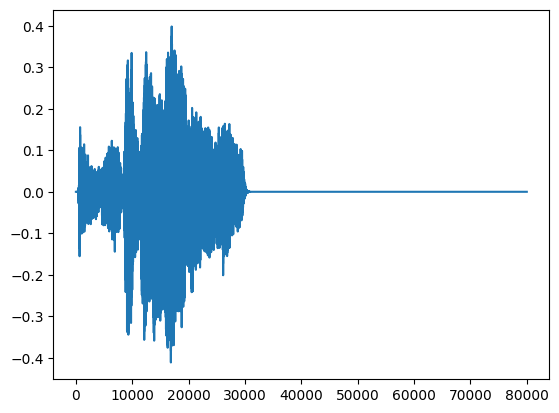

In [9]:
sample_wav_data = read_wav_file(pd_data["filename"].tolist()[52])
plt.plot(sample_wav_data[:, 0])
plt.show()

Plot a Spectrogram

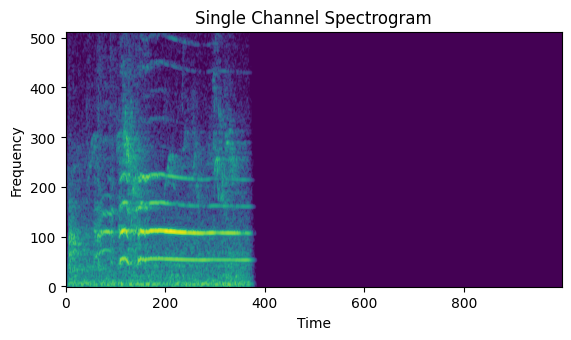

In [10]:
plot_single_spectrogram(sample_wav_data)

Plot a multi-bandwidth spectrogram

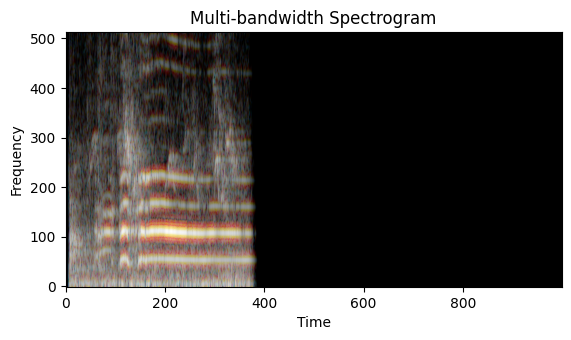

In [11]:
plot_multi_bandwidth_spectrogram(sample_wav_data)

### Define functions to construct a TF Dataset

In [12]:
def read_dataset(df, folds):
    msk = df["fold"].isin(folds)
    filenames = df["filename"][msk]
    targets = df["target"][msk].values
    waves = np.array(
        [read_wav_file(fil) for fil in filenames], dtype=np.float32
    )
    return waves, targets

### Create the datasets

In [13]:
train_x, train_y = read_dataset(pd_data, [1, 2, 3])
valid_x, valid_y = read_dataset(pd_data, [4])
test_x, test_y = read_dataset(pd_data, [5])

## Training the Models

In this tutorial we demonstrate the different usecases of the `STFTSpectrogram`
layer.

The first model will use a non-trainable `STFTSpectrogram` layer, so it is
intended purely for preprocessing. Additionally, the model will use 1D signals,
hence it make use of Conv1D layers.

The second model will use a trainable `STFTSpectrogram` layer with the
`expand_dims` option, which expands the shapes to be compatible with image
models.

### Create the 1D model

1. Create a non-trainable spectrograms, extracting a 1D time signal.
2. Apply `Conv1D` layers with `LayerNormalization` simialar to the
   classic VGG design.
4. Apply global maximum pooling to have fixed set of features.
5. Add `Dense` layers to make the final predictions based on the features.

In [14]:
model1d = keras.Sequential(
    [
        layers.InputLayer((None, 1)),
        layers.STFTSpectrogram(
            mode="log",
            frame_length=SAMPLE_RATE * 40 // 1000,
            frame_step=SAMPLE_RATE * 15 // 1000,
            trainable=False,
        ),
        layers.Conv1D(64, 64, activation="relu"),
        layers.Conv1D(128, 16, activation="relu"),
        layers.LayerNormalization(),
        layers.MaxPooling1D(4),
        layers.Conv1D(128, 8, activation="relu"),
        layers.Conv1D(256, 8, activation="relu"),
        layers.Conv1D(512, 4, activation="relu"),
        layers.LayerNormalization(),
        layers.Dropout(0.5),
        layers.GlobalMaxPooling1D(),
        layers.Dense(256, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ],
    name="model_1d_non_trainble_stft",
)
model1d.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model1d.summary()

Model: "model_1d_non_trainble_stft"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ stft_spectrogram_4 (STFTSpectrogram) │ (None, None, 513)           │         656,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, None, 64)            │       2,101,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, None, 128)           │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization                  │ (None, None, 128)           │             256 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, None, 128)           │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, None, 256)           │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, None, 512)           │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_1                │ (None, None, 512)           │           1,024 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 512)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,008,522 (15.29 MB)

 Trainable params: 3,351,882 (12.79 MB)

 Non-trainable params: 656,640 (2.50 MB)

Train the model and restore the best weights.

In [15]:
history_model1d = model1d.fit(
    train_x,
    train_y,
    batch_size=BATCH_SIZE,
    validation_data=(valid_x, valid_y),
    epochs=EPOCHS,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=EPOCHS,
            restore_best_weights=True,
        )
    ],
)

Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 271ms/step - accuracy: 0.1092 - loss: 3.1307 - val_accuracy: 0.0875 - val_loss: 2.4073
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1434 - loss: 2.6563 - val_accuracy: 0.1000 - val_loss: 2.4051
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1324 - loss: 2.5414 - val_accuracy: 0.1000 - val_loss: 2.4050
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1552 - loss: 2.4542 - val_accuracy: 0.1000 - val_loss: 2.3832
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1204 - loss: 2.3896 - val_accuracy: 0.1000 - val_loss: 2.3405
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1210 - loss: 2.3499 - val_accuracy: 0.1000 - val_loss: 2.3108
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1547 - loss: 2.2899 - val_accuracy: 0.1000 - val_loss: 2.2994
Epoch 8/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1672 - loss: 2.2049 - val_accuracy: 0.1250 -

### Create the 2D model

1. Create three spectrograms with multiple band-widths from the raw input.
2. Concatenate the three spectrograms to have three channels.
3. Load `MobileNet` and set the weights from the weights trained on `ImageNet`.
4. Apply global maximum pooling to have fixed set of features.
5. Add `Dense` layers to make the final predictions based on the features.

In [16]:
input = layers.Input((None, 1))
spectrograms = [
    layers.STFTSpectrogram(
        mode="log",
        frame_length=SAMPLE_RATE * frame_size // 1000,
        frame_step=SAMPLE_RATE * 15 // 1000,
        fft_length=2048,
        padding="same",
        expand_dims=True,
        # trainable=True,  # trainable by default
    )(input)
    for frame_size in [30, 40, 50]  # frame size in milliseconds
]

multi_spectrograms = layers.Concatenate(axis=-1)(spectrograms)

img_model = keras.applications.MobileNet(include_top=False, pooling="max")
output = img_model(multi_spectrograms)

output = layers.Dropout(0.5)(output)
output = layers.Dense(256, activation="relu")(output)
output = layers.Dense(256, activation="relu")(output)
output = layers.Dense(NUM_CLASSES, activation="softmax")(output)
model2d = keras.Model(input, output, name="model_2d_trainble_stft")

model2d.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model2d.summary()

<ipython-input-16-bf7092b3c6d2>:17: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  img_model = keras.applications.MobileNet(include_top=False, pooling="max")


Model: "model_2d_trainble_stft"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, None, 1)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stft_spectrogram_5        │ (None, None, 1025, 1)  │        984,000 │ input_layer_1[0][0]    │
│ (STFTSpectrogram)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stft_spectrogram_6        │ (None, None, 1025, 1)  │      1,312,000 │ input_layer_1[0][0]    │
│ (STFTSpectrogram)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stft_spectrogram_7        │ (None, None, 1025, 1)  │      1,640,000 │ input_layer_1[0][0]    │
│ (STFTSpectrogram)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, None, 1025, 3)  │              0 │ stft_spectrogram_5[0]… │
│                           │                        │                │ stft_spectrogram_6[0]… │
│                           │                        │                │ stft_spectrogram_7[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobilenet_1.00_224        │ (None, 1024)           │      3,228,864 │ concatenate[0][0]      │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 1024)           │              0 │ mobilenet_1.00_224[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 256)            │        262,400 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 256)            │         65,792 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 10)             │          2,570 │ dense_4[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 7,495,626 (28.59 MB)

 Trainable params: 7,473,738 (28.51 MB)

 Non-trainable params: 21,888 (85.50 KB)

Train the model and restore the best weights.

In [17]:
history_model2d = model2d.fit(
    train_x,
    train_y,
    batch_size=BATCH_SIZE,
    validation_data=(valid_x, valid_y),
    epochs=EPOCHS,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=EPOCHS,
            restore_best_weights=True,
        )
    ],
)

Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 50s 776ms/step - accuracy: 0.0855 - loss: 7.6484 - val_accuracy: 0.0625 - val_loss: 3.7484
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.1293 - loss: 5.8848 - val_accuracy: 0.0750 - val_loss: 4.0622
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.1302 - loss: 4.6363 - val_accuracy: 0.0875 - val_loss: 3.6488
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.1656 - loss: 4.6861 - val_accuracy: 0.1250 - val_loss: 3.5224
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.2025 - loss: 4.3601 - val_accuracy: 0.0875 - val_loss: 4.0424
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.2072 - loss: 3.8723 - val_accuracy: 0.1125 - val_loss: 3.1530
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.2562 - loss: 3.2596 - val_accuracy: 0.1125 - val_loss: 2.9712
Epoch 8/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.2328 - loss: 3.1374 - val_accuracy: 

### Plot Training History

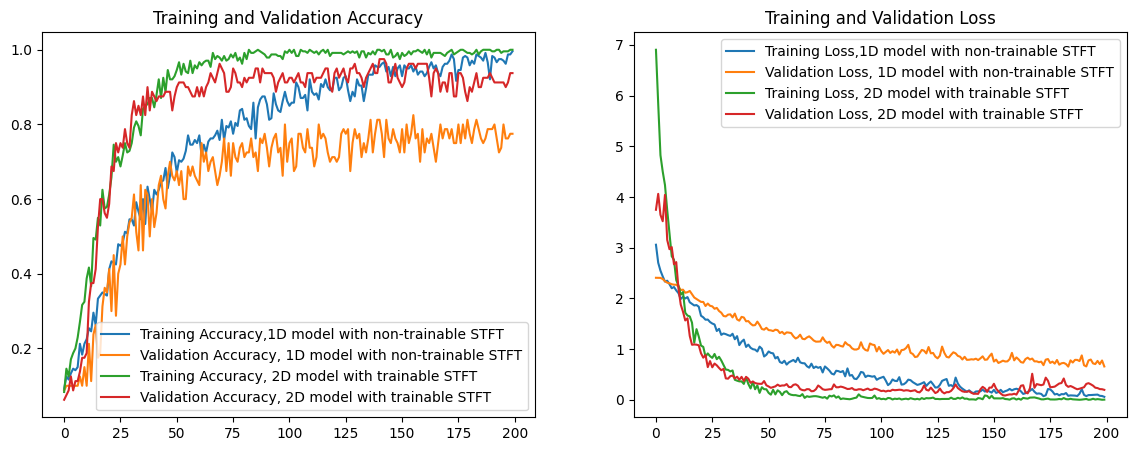

In [18]:
epochs_range = range(EPOCHS)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(
    epochs_range,
    history_model1d.history["accuracy"],
    label="Training Accuracy,1D model with non-trainable STFT",
)
plt.plot(
    epochs_range,
    history_model1d.history["val_accuracy"],
    label="Validation Accuracy, 1D model with non-trainable STFT",
)
plt.plot(
    epochs_range,
    history_model2d.history["accuracy"],
    label="Training Accuracy, 2D model with trainable STFT",
)
plt.plot(
    epochs_range,
    history_model2d.history["val_accuracy"],
    label="Validation Accuracy, 2D model with trainable STFT",
)
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(
    epochs_range,
    history_model1d.history["loss"],
    label="Training Loss,1D model with non-trainable STFT",
)
plt.plot(
    epochs_range,
    history_model1d.history["val_loss"],
    label="Validation Loss, 1D model with non-trainable STFT",
)
plt.plot(
    epochs_range,
    history_model2d.history["loss"],
    label="Training Loss, 2D model with trainable STFT",
)
plt.plot(
    epochs_range,
    history_model2d.history["val_loss"],
    label="Validation Loss, 2D model with trainable STFT",
)
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

### Evaluate on Test Data


Running the models on the test set.

In [19]:
_, test_acc = model1d.evaluate(test_x, test_y)
print(
    f"1D model wit non-trainable STFT -> Test Accuracy: {test_acc * 100:.2f}%"
)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 307ms/step - accuracy: 0.8148 - loss: 0.6244
1D model wit non-trainable STFT -> Test Accuracy: 82.50%


In [20]:
_, test_acc = model2d.evaluate(test_x, test_y)
print(f"2D model with trainable STFT -> Test Accuracy: {test_acc * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 546ms/step - accuracy: 0.9195 - loss: 0.5271
2D model with trainable STFT -> Test Accuracy: 92.50%
